# 📊 Model Comparison — Rossmann Store Sales
**Notebook 05** — Final Comparison (SARIMAX + RF + XGBoost)

| Model | Type | Scope |
|---|---|---|
| SARIMAX(2,1,2)+exog | Statistical | Store 1 only |
| Random Forest | ML Ensemble | All 1,115 stores |
| **XGBoost** | **ML Boosting** | **All 1,115 stores** |

## 1. Imports & Config

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pickle, warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.figsize': (14, 5), 'axes.titlesize': 13})

STORE_ID = 1

EXOG_FEATURES = [
    'Promo', 'SchoolHoliday', 'IsPublicHoliday', 'IsChristmas',
    'IsMonday', 'IsSaturday', 'IsMonthEnd', 'IsQ4',
    'BeforeHoliday', 'AfterHoliday', 'Promo_x_Monday', 'Promo_x_SchoolHol',
    'fourier_weekly_sin_7_1', 'fourier_weekly_cos_7_1',
    'fourier_annual_sin_365_1', 'fourier_annual_cos_365_1',
]

print('Imports done ✅')

Imports done ✅


## 2. Load Data & ML Models

In [10]:
val_df       = pd.read_csv('../data/processed/val_featured.csv', parse_dates=['Date'])
feature_cols = pd.read_csv('../data/processed/feature_list.csv')['feature'].tolist()
feature_cols = [f for f in feature_cols if f in val_df.columns]

X_val        = val_df[feature_cols].fillna(0)
y_val_actual = np.expm1(val_df['Sales_log'].values)

print(f'Val samples : {len(val_df):,}')
print(f'Features    : {len(feature_cols)}')

Val samples : 168,380
Features    : 104


In [11]:
with open('../models/random_forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)
with open('../models/xgboost.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

print('ML models loaded ✅')

ML models loaded ✅


## 3. Generate All Predictions

In [12]:
# ── Step 1: ML predictions for all stores ────────────────────────────────────
rf_pred  = np.expm1(rf_model.predict(X_val))
xgb_pred = np.expm1(xgb_model.predict(X_val))

# ── Step 2: Refit SARIMAX on Store 1 (fixes ValueError #1) ──────────────────
full_df = pd.read_csv('../data/processed/featured_sales_data.csv',parse_dates=['Date'], low_memory=False)

store1_df = (
    full_df[full_df['Store'] == STORE_ID]
    .sort_values('Date')
    .set_index('Date')
    .dropna(subset=['Sales_log'])
)

exog_cols_present = [c for c in EXOG_FEATURES if c in store1_df.columns]
series_s1         = store1_df['Sales_log']
exog_s1           = store1_df[exog_cols_present].fillna(0).astype(float)

idx           = int(len(series_s1) * 0.80)
train_y_s1    = series_s1.iloc[:idx]
val_y_s1      = series_s1.iloc[idx:]
train_exog_s1 = exog_s1.iloc[:idx]
val_exog_s1   = exog_s1.iloc[idx:]

print('Refitting SARIMAX(2,1,2) on Store 1 train split...')
sarimax_refit = SARIMAX(
    train_y_s1, exog=train_exog_s1,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

sarimax_pred_raw   = np.expm1(sarimax_refit.forecast(steps=len(val_y_s1), exog=val_exog_s1).values)
sarimax_actual_raw = np.expm1(val_y_s1.values)
sarimax_dates      = val_y_s1.index

# ── Step 3: Align Store 1 arrays by Date (fixes ValueError #2) ───────────────
# SARIMAX val: from featured_sales_data.csv → may have more rows than val_featured.csv
# ML val:      from val_featured.csv         → may have fewer rows for Store 1
store_mask = (val_df['Store'] == STORE_ID).values

sarimax_df = pd.DataFrame({
    'actual'      : sarimax_actual_raw,
    'sarimax_pred': sarimax_pred_raw,
}, index=sarimax_dates)

ml_df = pd.DataFrame({
    'rf_pred' : rf_pred[store_mask],
    'xgb_pred': xgb_pred[store_mask],
}, index=pd.to_datetime(val_df.loc[store_mask, 'Date'].values))

# Inner join — keep only dates present in both
aligned    = sarimax_df.join(ml_df, how='inner')

act_a      = aligned['actual'].values
sx_a       = aligned['sarimax_pred'].values
rf_a       = aligned['rf_pred'].values
xgb_a      = aligned['xgb_pred'].values
dates_s1   = aligned.index

print(f'\nRow counts after alignment:')
print(f'  SARIMAX raw : {len(sarimax_actual_raw)}')
print(f'  ML Store 1  : {store_mask.sum()}')
print(f'  Aligned     : {len(aligned)}  ✅  (used for Store 1 plots & error analysis)')
print(f'\nRF / XGB global : {len(rf_pred):,} predictions (all stores)')

Refitting SARIMAX(2,1,2) on Store 1 train split...

Row counts after alignment:
  SARIMAX raw : 157
  ML Store 1  : 150
  Aligned     : 150  ✅  (used for Store 1 plots & error analysis)

RF / XGB global : 168,380 predictions (all stores)


## 4. Evaluate — MAE, RMSE, MAPE

In [13]:
def evaluate(actual, predicted, label):
    mae  = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / (actual + 1e-8))) * 100
    return {'Model': label, 'MAE': round(mae, 2),
            'RMSE': round(rmse, 2), 'MAPE%': round(mape, 2)}

results = [
    evaluate(y_val_actual, rf_pred,  'Random Forest'),
    evaluate(y_val_actual, xgb_pred, 'XGBoost'),
    evaluate(act_a, sx_a,            f'SARIMAX(2,1,2)+exog  [Store {STORE_ID}]'),
]
results_df = pd.DataFrame(results)
print('\n=== Model Comparison ===')
print(results_df.to_string(index=False))


=== Model Comparison ===
                         Model    MAE    RMSE  MAPE%
                 Random Forest 736.83 1098.15  10.66
                       XGBoost 644.67  933.08   9.33
SARIMAX(2,1,2)+exog  [Store 1] 489.65  653.29  10.20


## 5. MAE & RMSE Bar Chart

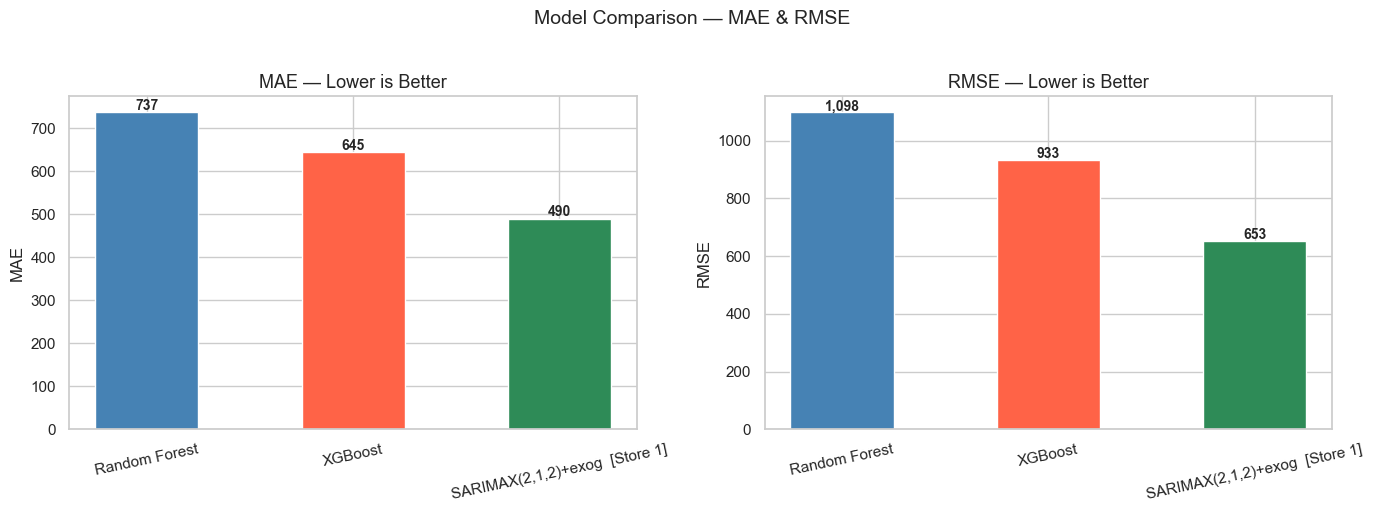

In [14]:
colors = ['steelblue', 'tomato', 'seagreen']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, metric in zip(axes, ['MAE', 'RMSE']):
    bars = ax.bar(results_df['Model'], results_df[metric],
                  color=colors, edgecolor='white', width=0.5)
    ax.set_title(f'{metric} — Lower is Better')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=12)
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{val:,.0f}', ha='center', fontweight='bold', fontsize=10)
plt.suptitle('Model Comparison — MAE & RMSE', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/final_comparison.png', dpi=150)
plt.show()

## 6. Actual vs Predicted — Store 1 (All Models)

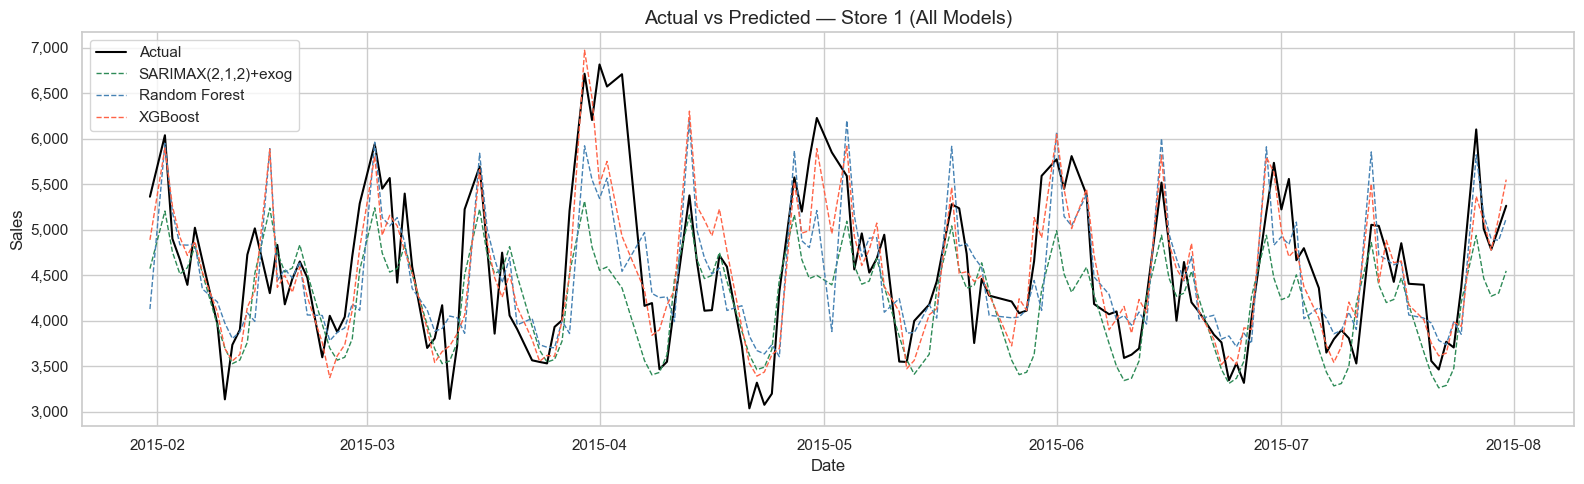

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(dates_s1, act_a,  color='black',    linewidth=1.5, label='Actual')
ax.plot(dates_s1, sx_a,   color='seagreen', linewidth=1.0,
        linestyle='--', label='SARIMAX(2,1,2)+exog')
ax.plot(dates_s1, rf_a,   color='steelblue',linewidth=1.0,
        linestyle='--', label='Random Forest')
ax.plot(dates_s1, xgb_a,  color='tomato',   linewidth=1.0,
        linestyle='--', label='XGBoost')
ax.set_title(f'Actual vs Predicted — Store {STORE_ID} (All Models)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/all_models_forecast.png', dpi=150)
plt.show()

## 7. Error Distribution Comparison — Store 1

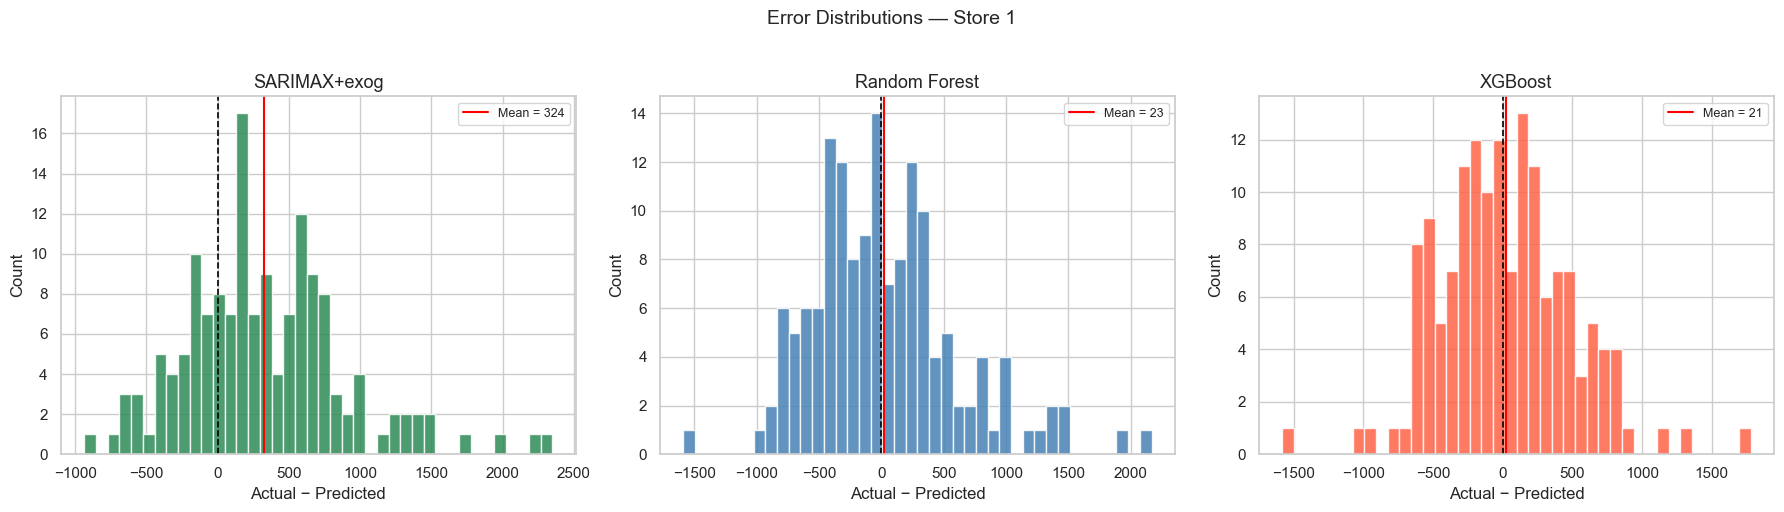

In [16]:
# All arrays now same length (aligned) — no shape mismatch
errors  = {
    'SARIMAX+exog' : act_a - sx_a,
    'Random Forest': act_a - rf_a,
    'XGBoost'      : act_a - xgb_a,
}
palette = ['seagreen', 'steelblue', 'tomato']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, err), color in zip(axes, errors.items(), palette):
    ax.hist(err, bins=40, color=color, edgecolor='white', alpha=0.85)
    ax.axvline(0,          color='black', linestyle='--', linewidth=1.2)
    ax.axvline(err.mean(), color='red',   linestyle='-',  linewidth=1.5,
               label=f'Mean = {err.mean():.0f}')
    ax.set_title(label)
    ax.set_xlabel('Actual − Predicted')
    ax.set_ylabel('Count')
    ax.legend(fontsize=9)
plt.suptitle(f'Error Distributions — Store {STORE_ID}', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/error_distributions.png', dpi=150)
plt.show()

## 8. Per-Store Error Analysis (ML Models — All Stores)

In [17]:
val_df['actual']   = y_val_actual
val_df['rf_pred']  = rf_pred
val_df['xgb_pred'] = xgb_pred

store_errors = val_df.groupby('Store').apply(
    lambda g: pd.Series({
        'RF_MAE' : mean_absolute_error(g['actual'], g['rf_pred']),
        'XGB_MAE': mean_absolute_error(g['actual'], g['xgb_pred']),
    })
).reset_index()

print('Per-store MAE stats:')
print(store_errors[['RF_MAE','XGB_MAE']].describe().round(1))

Per-store MAE stats:
       RF_MAE  XGB_MAE
count  1115.0   1115.0
mean    734.8    644.1
std     295.8    224.5
min     255.7    261.5
25%     536.6    497.2
50%     678.8    602.4
75%     841.4    730.6
max    2592.4   2152.9


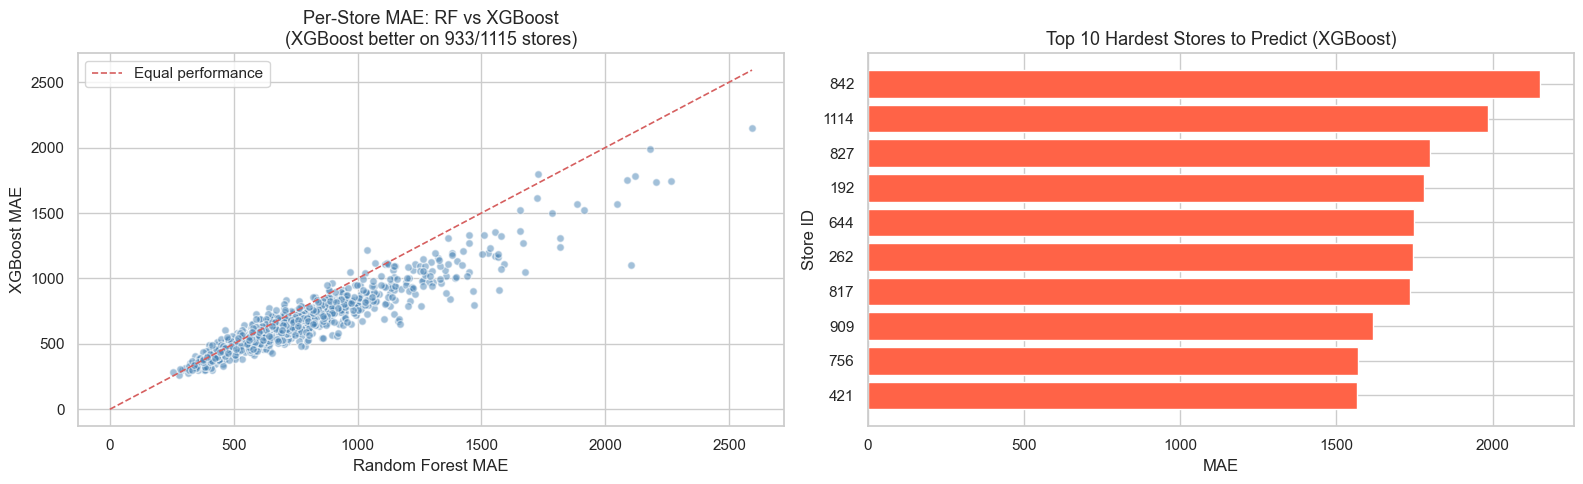

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].scatter(store_errors['RF_MAE'], store_errors['XGB_MAE'],
                alpha=0.5, s=30, color='steelblue', edgecolors='white')
max_val = max(store_errors['RF_MAE'].max(), store_errors['XGB_MAE'].max())
axes[0].plot([0,max_val],[0,max_val], 'r--', linewidth=1.2, label='Equal performance')
xgb_better = (store_errors['XGB_MAE'] < store_errors['RF_MAE']).sum()
axes[0].set_title(f'Per-Store MAE: RF vs XGBoost\n'
                  f'(XGBoost better on {xgb_better}/{len(store_errors)} stores)')
axes[0].set_xlabel('Random Forest MAE')
axes[0].set_ylabel('XGBoost MAE')
axes[0].legend()

hard = store_errors.sort_values('XGB_MAE', ascending=False).head(10)
axes[1].barh(hard['Store'].astype(str), hard['XGB_MAE'], color='tomato')
axes[1].set_title('Top 10 Hardest Stores to Predict (XGBoost)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('Store ID')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/per_store_mae.png', dpi=150)
plt.show()

## 9. XGBoost Error by Day & Month

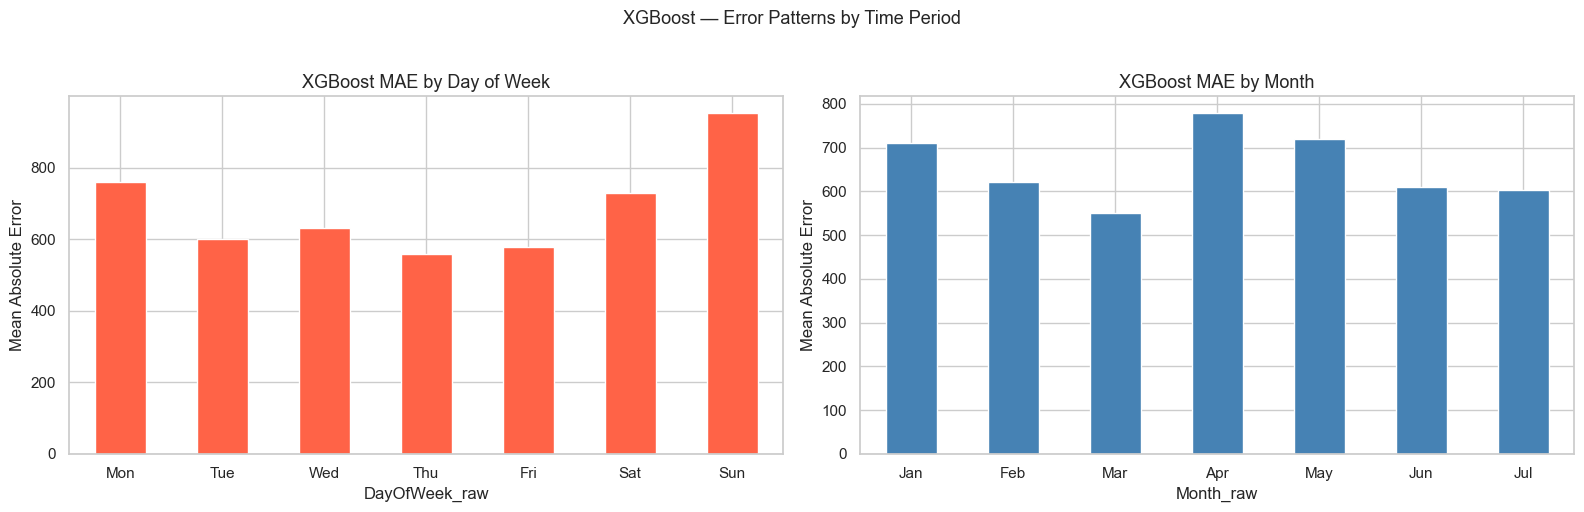

In [19]:
val_df['xgb_abs_err']   = np.abs(val_df['actual'] - val_df['xgb_pred'])
val_df['DayOfWeek_raw'] = val_df['Date'].dt.dayofweek
val_df['Month_raw']     = val_df['Date'].dt.month

dow_map   = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
             7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

dow_mae   = val_df.groupby('DayOfWeek_raw')['xgb_abs_err'].mean().rename(index=dow_map)
month_mae = val_df.groupby('Month_raw')['xgb_abs_err'].mean().rename(index=month_map)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
dow_mae.plot(  kind='bar', ax=axes[0], color='tomato',    edgecolor='white', rot=0)
axes[0].set_title('XGBoost MAE by Day of Week')
axes[0].set_ylabel('Mean Absolute Error')
month_mae.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='white', rot=0)
axes[1].set_title('XGBoost MAE by Month')
axes[1].set_ylabel('Mean Absolute Error')
plt.suptitle('XGBoost — Error Patterns by Time Period', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/xgb_error_patterns.png', dpi=150)
plt.show()

## 10. XGBoost — Actual vs Predicted Scatter

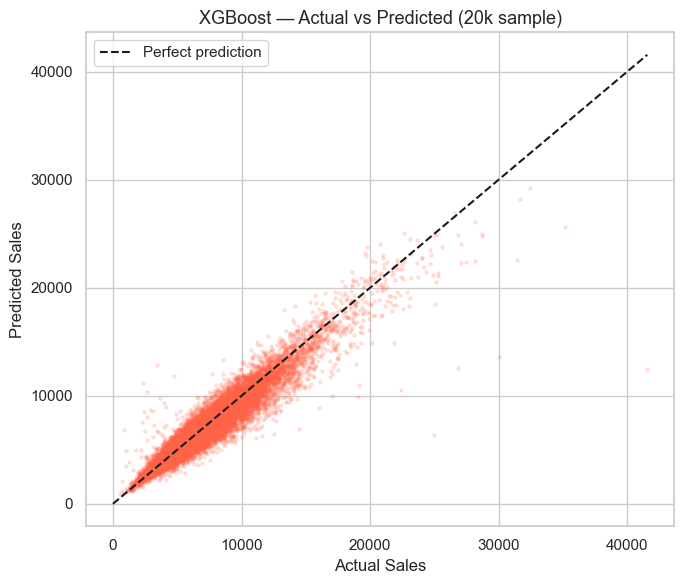

In [20]:
sample_idx = np.random.choice(len(y_val_actual), size=20000, replace=False)
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_val_actual[sample_idx], xgb_pred[sample_idx],
           alpha=0.15, s=5, color='tomato')
m = max(y_val_actual.max(), xgb_pred.max())
ax.plot([0,m],[0,m], 'k--', linewidth=1.5, label='Perfect prediction')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')
ax.set_title('XGBoost — Actual vs Predicted (20k sample)')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/xgb_actual_vs_pred.png', dpi=150)
plt.show()

## 11. Save Results & Final Summary

In [21]:
results_df['Scope']    = ['All 1115 stores', 'All 1115 stores', f'Store {STORE_ID} only']
results_df['Features'] = ['94', '94', f'{len(exog_cols_present)} exog']
results_df.to_csv('../reports/final_comparison.csv', index=False)
print('Saved → reports/final_comparison.csv ✅')
print()
print(results_df.to_string(index=False))

Saved → reports/final_comparison.csv ✅

                         Model    MAE    RMSE  MAPE%           Scope Features
                 Random Forest 736.83 1098.15  10.66 All 1115 stores       94
                       XGBoost 644.67  933.08   9.33 All 1115 stores       94
SARIMAX(2,1,2)+exog  [Store 1] 489.65  653.29  10.20    Store 1 only  16 exog


## SALES FORECASTING PROJECT — FINAL SUMMARY                  

Dataset   : Rossmann (1115 stores, 2013-2015)                  
Train     : 675,958 rows  |  Val: 168,380 rows                 
Features  : 94 engineered features                             

RESULTS                                                         
Random Forest    MAE: 736.83    RMSE: 1098.15  (all stores) 
XGBoost [BEST]   MAE: 644.67    RMSE: 933.08   (all stores) 
SARIMAX+exog     MAE: 489.65    RMSE: 653.29   (Store 1)    

### KEY FINDINGS                                                    
* Lag & rolling features = strongest predictors                
* Promo boosts sales (EDA + ML + SARIMAX all confirmed)        
* XGBoost best across all 1115 stores                          
* SARIMAX >> plain ARIMA thanks to exogenous features          
* December & Monday show highest prediction error